## Speed–accuracy trade-off in our data

### preparation:

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

file_path = 'data_ddm.csv'
data = pd.read_csv(file_path)

In [8]:
data['correct'] = data['choice'] == 'correct'
data['id'] = data['id'].astype(str)

young_data = data[~data['id'].str.startswith('o')]
old_data = data[data['id'].str.startswith('o')]

# mean accuracy and response time per subject for a given condition
def calculate_subject_means(dataset, condition):
    condition_data = dataset[dataset['cond'] == condition]
    subject_means = condition_data.groupby('id').agg({'correct': 'mean', 'rt': 'mean'}).reset_index()
    return subject_means['correct'], subject_means['rt']

# mean accuracy and response time per subject for each group
young_pro_acc_subj, young_pro_rt_subj = calculate_subject_means(young_data, 'pro')
young_anti_acc_subj, young_anti_rt_subj = calculate_subject_means(young_data, 'anti')
old_pro_acc_subj, old_pro_rt_subj = calculate_subject_means(old_data, 'pro')
old_anti_acc_subj, old_anti_rt_subj = calculate_subject_means(old_data, 'anti')



### 1. raw data:

Below is the plot for each of the four groups: pro-saccade young, anti-saccade young, pro-saccade old, and anti-saccade old.

We  calculate the mean accuracy and mean response time for each subject within each condition and age group and then plot these as individual points.

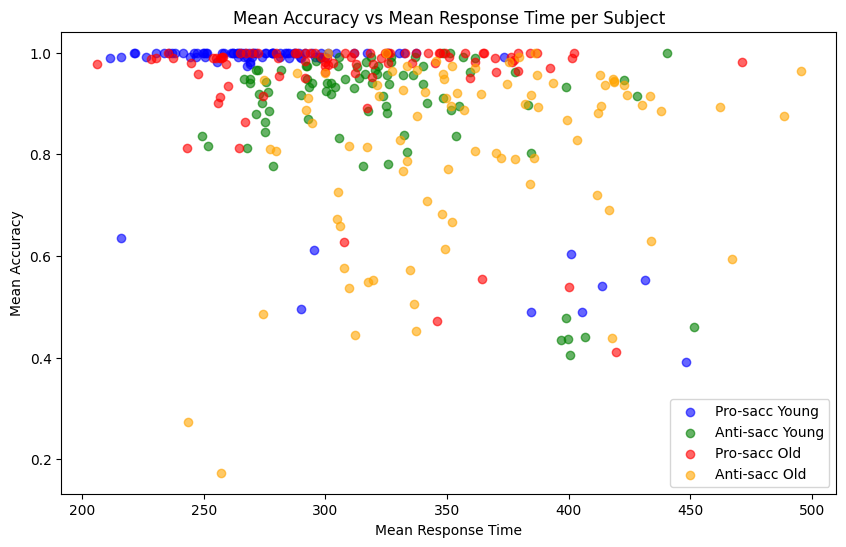

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(young_pro_rt_subj, young_pro_acc_subj, label='Pro-sacc Young', color='blue', alpha=0.6)
plt.scatter(young_anti_rt_subj, young_anti_acc_subj, label='Anti-sacc Young', color='green', alpha=0.6)
plt.scatter(old_pro_rt_subj, old_pro_acc_subj, label='Pro-sacc Old', color='red', alpha=0.6)
plt.scatter(old_anti_rt_subj, old_anti_acc_subj, label='Anti-sacc Old', color='orange', alpha=0.6)
plt.xlabel('Mean Response Time')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Mean Response Time per Subject')
plt.legend()
plt.show()


### 2. Continuous curves

 Below, Updated analysis to provide a plot with continuous curves that reflect changes in accuracy over different response times for each group. ​​

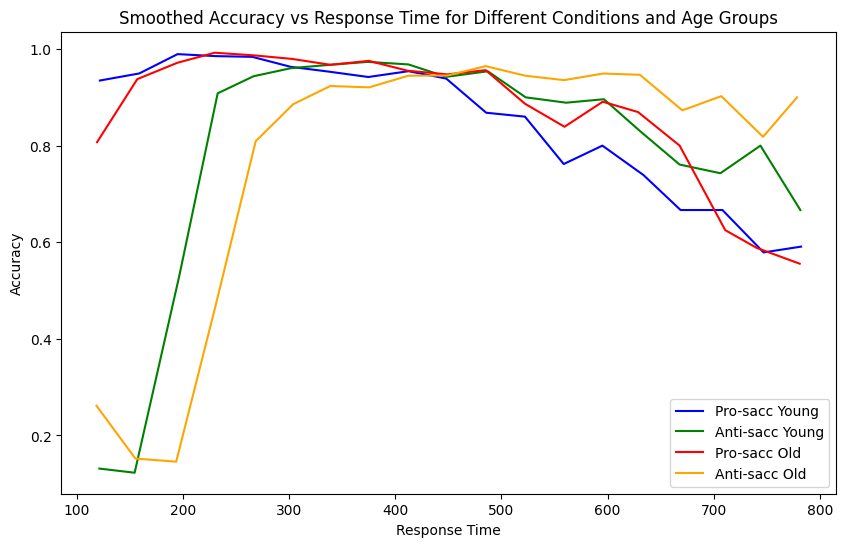

In [10]:
# Function to calculate accuracy and average response time in bins for smoother curves
def calculate_accuracy_rt_bins(dataset, condition, bins):
    condition_data = dataset[dataset['cond'] == condition].copy()
    condition_data.loc[:, 'rt_bin'] = pd.cut(condition_data['rt'], bins=bins, labels=range(len(bins)-1))
    # Calculating mean accuracy and response time per bin
    accuracy_rt_bins = condition_data.groupby('rt_bin').agg({'correct': 'mean', 'rt': 'mean'})
    return accuracy_rt_bins['correct'], accuracy_rt_bins['rt']

young_data = data[~data['id'].astype(str).str.startswith('o')]
old_data = data[data['id'].astype(str).str.startswith('o')]

# Define bins for response time, here 
rt_bins = np.linspace(data['rt'].min(), data['rt'].max(), 20)

young_pro_acc_bins, young_pro_rt_bins = calculate_accuracy_rt_bins(young_data, 'pro', rt_bins)
young_anti_acc_bins, young_anti_rt_bins = calculate_accuracy_rt_bins(young_data, 'anti', rt_bins)
old_pro_acc_bins, old_pro_rt_bins = calculate_accuracy_rt_bins(old_data, 'pro', rt_bins)
old_anti_acc_bins, old_anti_rt_bins = calculate_accuracy_rt_bins(old_data, 'anti', rt_bins)

plt.figure(figsize=(10, 6))

plt.plot(young_pro_rt_bins, young_pro_acc_bins, label='Pro-sacc Young', color='blue')
plt.plot(young_anti_rt_bins, young_anti_acc_bins, label='Anti-sacc Young', color='green')
plt.plot(old_pro_rt_bins, old_pro_acc_bins, label='Pro-sacc Old', color='red')
plt.plot(old_anti_rt_bins, old_anti_acc_bins, label='Anti-sacc Old', color='orange')
plt.xlabel('Response Time')
plt.ylabel('Accuracy')
plt.title('Smoothed Accuracy vs Response Time for Different Conditions and Age Groups')
plt.legend()
plt.show()


### 3. Speed–accuracy trade-off (SAT) functions with best-fitting exponential curves. 





Below, we fit an exponential model to each of the data sets for the different conditions and age groups.
then we use the model to generate predicted accuracy values over a range of response times.
Thisgive us a continuous curve that best represents the relationship between speed and accuracy for each condition and age group, following the methodology from the paper you sent me: https://www.researchgate.net/publication/264702567_Interactions_between_voluntary_and_involuntary_attention_modulate_the_quality_and_temporal_dynamics_of_visual_processing

below we fit exponential functions to the data for each group.


/home/ubuntu/.local/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


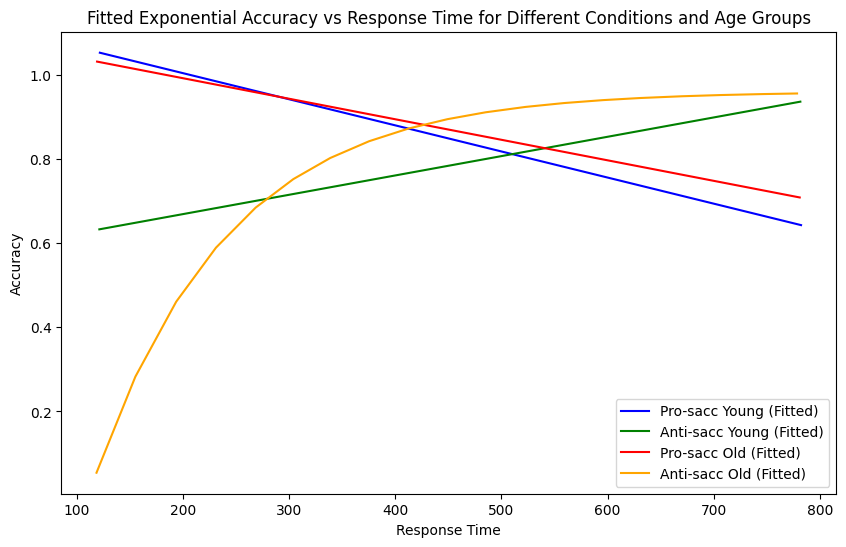

In [11]:
# eexponential fit
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def prepare_data_for_fitting(acc_bins, rt_bins):
    valid_data = ~(acc_bins.isna() | rt_bins.isna())
    return rt_bins[valid_data], acc_bins[valid_data]


def fit_exponential_function(x, y):
    init_param = (max(y), 0.01, min(y))
    params, params_covariance = curve_fit(exp_func, x, y, p0=init_param, maxfev=5000)
    fitted_values = exp_func(x, *params)
    
    return x, fitted_values, params

try:
    young_pro_rt_fit, young_pro_acc_fit, young_pro_params = fit_exponential_function(*prepare_data_for_fitting(young_pro_acc_bins, young_pro_rt_bins))
    young_anti_rt_fit, young_anti_acc_fit, young_anti_params = fit_exponential_function(*prepare_data_for_fitting(young_anti_acc_bins, young_anti_rt_bins))
    old_pro_rt_fit, old_pro_acc_fit, old_pro_params = fit_exponential_function(*prepare_data_for_fitting(old_pro_acc_bins, old_pro_rt_bins))
    old_anti_rt_fit, old_anti_acc_fit, old_anti_params = fit_exponential_function(*prepare_data_for_fitting(old_anti_acc_bins, old_anti_rt_bins))

    plt.figure(figsize=(10, 6))

    plt.plot(young_pro_rt_fit, young_pro_acc_fit, label='Pro-sacc Young (Fitted)', color='blue')
    plt.plot(young_anti_rt_fit, young_anti_acc_fit, label='Anti-sacc Young (Fitted)', color='green')
    plt.plot(old_pro_rt_fit, old_pro_acc_fit, label='Pro-sacc Old (Fitted)', color='red')
    plt.plot(old_anti_rt_fit, old_anti_acc_fit, label='Anti-sacc Old (Fitted)', color='orange')

    plt.xlabel('Response Time')
    plt.ylabel('Accuracy')
    plt.title('Fitted Exponential Accuracy vs Response Time for Different Conditions and Age Groups')
    plt.legend()

    plt.show()
except RuntimeError as e:
    print(f"change initial params or maxfev: {e}")


### 4. sigmoid approach
Using a more complicate model that can better handle the characteristics of the data for each group.

(sing a different type of curve fitting that may provide a better fit, such as a sigmoidal function which is often used in psychometric curves and may resemble the exponential fit in certain aspects)


/home/ubuntu/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


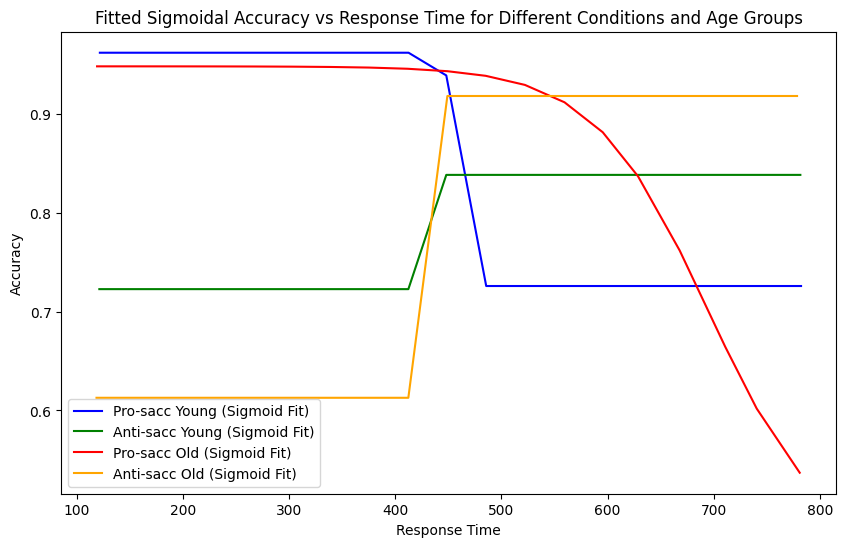

In [12]:
def sigmoid_func(x, a, b, c, d):
    # a = curve's max value, b = curve's steepness (slope), c = curve's midpoint, d = curve's min value
    return ((a - d) / (1.0 + np.exp(-b * (x - c)))) + d

def fit_sigmoid_function(x, y):
    # Initial parameterss: a - max value, b - slope, c - midpoint, d - min value
    init = (max(y), 1.0, np.median(x), min(y))
    
    # Fit the sigmoid function to the data
    params, params_covariance = curve_fit(sigmoid_func, x, y, p0=init, maxfev=5000)
    
    fitted_values = sigmoid_func(x, *params)
    
    return x, fitted_values, params

try:
    young_pro_rt_sigmoid, young_pro_acc_sigmoid, young_pro_params_sigmoid = fit_sigmoid_function(*prepare_data_for_fitting(young_pro_acc_bins, young_pro_rt_bins))
    young_anti_rt_sigmoid, young_anti_acc_sigmoid, young_anti_params_sigmoid = fit_sigmoid_function(*prepare_data_for_fitting(young_anti_acc_bins, young_anti_rt_bins))
    old_pro_rt_sigmoid, old_pro_acc_sigmoid, old_pro_params_sigmoid = fit_sigmoid_function(*prepare_data_for_fitting(old_pro_acc_bins, old_pro_rt_bins))
    old_anti_rt_sigmoid, old_anti_acc_sigmoid, old_anti_params_sigmoid = fit_sigmoid_function(*prepare_data_for_fitting(old_anti_acc_bins, old_anti_rt_bins))

    plt.figure(figsize=(10, 6))

    plt.plot(young_pro_rt_sigmoid, young_pro_acc_sigmoid, label='Pro-sacc Young (Sigmoid Fit)', color='blue')
    plt.plot(young_anti_rt_sigmoid, young_anti_acc_sigmoid, label='Anti-sacc Young (Sigmoid Fit)', color='green')
    plt.plot(old_pro_rt_sigmoid, old_pro_acc_sigmoid, label='Pro-sacc Old (Sigmoid Fit)', color='red')
    plt.plot(old_anti_rt_sigmoid, old_anti_acc_sigmoid, label='Anti-sacc Old (Sigmoid Fit)', color='orange')

    plt.xlabel('Response Time')
    plt.ylabel('Accuracy')
    plt.title('Fitted Sigmoidal Accuracy vs Response Time for Different Conditions and Age Groups')
    plt.legend()

    plt.show()
except RuntimeError as e:
    print(f"change initial params or maxfev: {e}")

